In [1]:
import torch
import os
import timm
import time
import torchinfo
import psutil
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from timm.utils.model import reparameterize_model
from network import *
from torch.utils.data import DataLoader
from dataset import *

In [2]:
def measure_latency(model, inputs, device):
    inputs = inputs.to(device)
    model = model.to(device)
    
    start = time.perf_counter()
    with torch.no_grad():
        output = model(inputs)
    end = time.perf_counter()
    
    latency = end - start
    return latency


def measure_cpu_throughput(model, inputs, batch_size):
    inputs = inputs.to("cpu")
    model = model.to("cpu")
    
    start = time.perf_counter()
    with torch.no_grad():
        for i in range(0, inputs.size(0), batch_size):
            output = model(inputs[i:i + batch_size])
    end = time.perf_counter()
    
    latency = end - start
    throughput = inputs.size(0) / latency
    return throughput


def measure_gpu_throughput(model, inputs, batch_size):
    inputs = inputs.to("cuda")
    model = model.to("cuda")
    
    start = time.perf_counter()
    with torch.no_grad():
        for i in range(0, inputs.size(0), batch_size):
            output = model(inputs[i:i + batch_size])
    end = time.perf_counter()
    
    latency = end - start
    throughput = inputs.size(0) / latency
    return throughput

In [24]:
ckpt_path = r"./checkpoint/fastvit_sa12_fine-tuning_000110.pt"
checkpoint = torch.load(ckpt_path, map_location=lambda storage, loc: storage)

num_classes = 1
in_chans = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, model_cfg = fastvit_sa12(num_classes, in_chans, device)
model.load_state_dict(checkpoint["model"])
model.eval()
model = reparameterize_model(model)

In [25]:
transform = transforms.Compose([
    transforms.Resize(size=model_cfg["input_size"][1:], interpolation=model_cfg["interpolation"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=model_cfg["mean"], std=model_cfg["std"]),
])

data_path = r"./Aircraft-FOD-DS-v2-Day-Binary-Reduced"
test_path = os.path.join(data_path, "test")
test_ds = ImageDataset(
    root_dir=test_path,
    num_classes=num_classes,
    transform=transform,
    # target_transform=target_transform
)

test_dl = DataLoader(test_ds, batch_size=128, pin_memory=True, shuffle=False, num_workers=10, persistent_workers=True)

## Performance evaluation

### 1. Latency and throughput

In [131]:
max_batch_size = 32
iterations = 300
input_size = list(model_cfg["input_size"])
stats = {"cpu_latency": [], "cpu_throughput": [], "gpu_latency": [], "gpu_throughput": []}

for batch_size in range(1, max_batch_size + 1):
    print(f"Batch size: {batch_size}")
    size = [batch_size] + input_size
    inputs = torch.randn(size)

    device = "cpu"
    cpu_latency = []
    for i in range(iterations):
        latency = measure_latency(model, inputs, device)
        cpu_latency.append(latency)
    cpu_latency = np.mean(cpu_latency) * 1000
    cpu_throughput = 1000 * batch_size / cpu_latency

    device = "cuda"
    gpu_latency = []
    for i in range(iterations):
        latency = measure_latency(model, inputs, device)
        gpu_latency.append(latency)
    gpu_latency = np.mean(gpu_latency) * 1000
    gpu_throughput = 1000 * batch_size / gpu_latency
    
    cpu_latency = round(cpu_latency, 1)
    cpu_throughput = round(cpu_throughput, 1)
    gpu_latency = round(gpu_latency, 1)
    gpu_throughput = round(gpu_throughput, 1)
    print(f"CPU latency, ms: {cpu_latency}")
    print(f"CPU throughput: {cpu_throughput}")
    print(f"GPU latency, ms: {gpu_latency}")
    print(f"GPU throughput: {gpu_throughput}")
    print()
    
    stats["cpu_latency"].append(cpu_latency)
    stats["cpu_throughput"].append(cpu_throughput)
    stats["gpu_latency"].append(gpu_latency)
    stats["gpu_throughput"].append(gpu_throughput)

Batch size: 1
CPU latency, ms: 23.5
CPU throughput: 42.6
GPU latency, ms: 3.8
GPU throughput: 266.5

Batch size: 2
CPU latency, ms: 31.1
CPU throughput: 64.2
GPU latency, ms: 4.0
GPU throughput: 494.6

Batch size: 3
CPU latency, ms: 40.0
CPU throughput: 75.1
GPU latency, ms: 4.0
GPU throughput: 749.7

Batch size: 4
CPU latency, ms: 42.8
CPU throughput: 93.4
GPU latency, ms: 3.9
GPU throughput: 1025.4

Batch size: 5
CPU latency, ms: 49.2
CPU throughput: 101.6
GPU latency, ms: 3.9
GPU throughput: 1296.2

Batch size: 6
CPU latency, ms: 66.4
CPU throughput: 90.4
GPU latency, ms: 3.9
GPU throughput: 1544.6

Batch size: 7
CPU latency, ms: 85.1
CPU throughput: 82.3
GPU latency, ms: 4.0
GPU throughput: 1767.9

Batch size: 8
CPU latency, ms: 101.7
CPU throughput: 78.7
GPU latency, ms: 3.9
GPU throughput: 2028.7

Batch size: 9
CPU latency, ms: 107.9
CPU throughput: 83.4
GPU latency, ms: 4.0
GPU throughput: 2278.2

Batch size: 10
CPU latency, ms: 118.6
CPU throughput: 84.3
GPU latency, ms: 3.9
GP

In [160]:
plt.style.use("seaborn-bright")
plt.rcParams.update({"font.size": 12})
dpi = 100

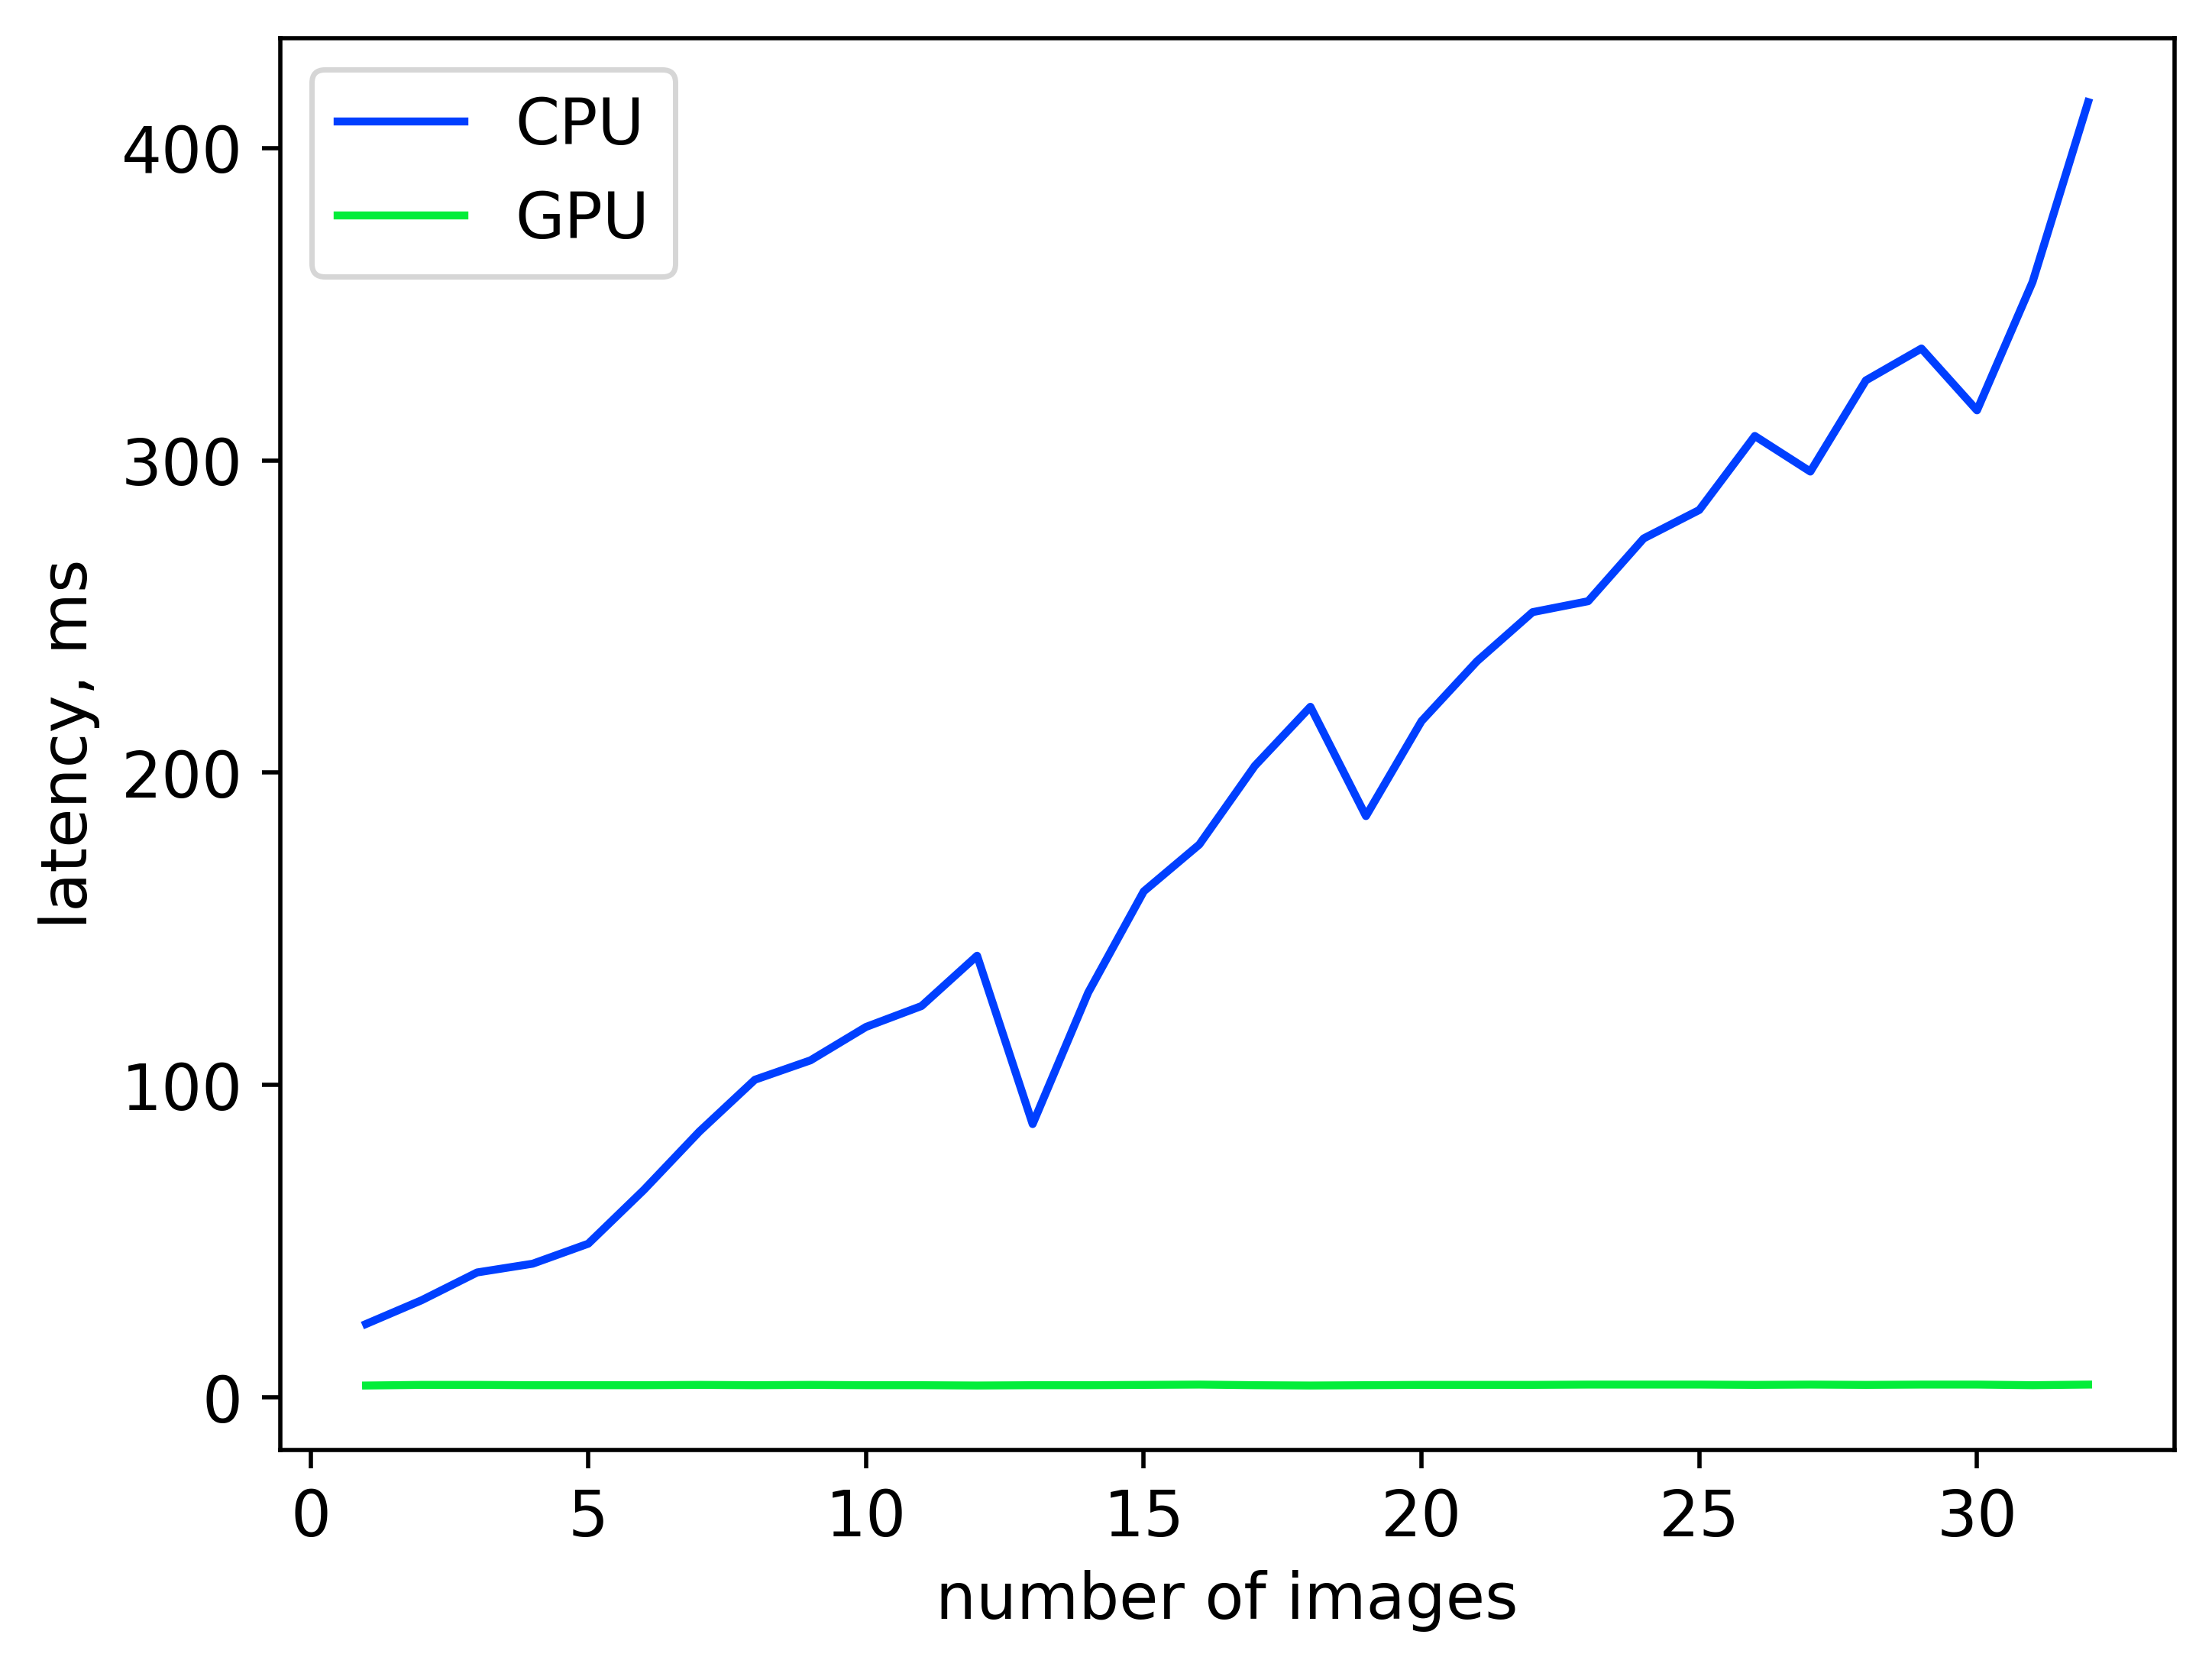

In [164]:
fig, ax = plt.subplots(dpi=dpi)
x = list(range(1, max_batch_size + 1))
ax.plot(x, stats["cpu_latency"], label="CPU")
ax.plot(x, stats["gpu_latency"], label="GPU")
ax.set_xlabel("number of images")
ax.set_ylabel("latency, ms")
ax.legend()
fig.savefig("latency.png")

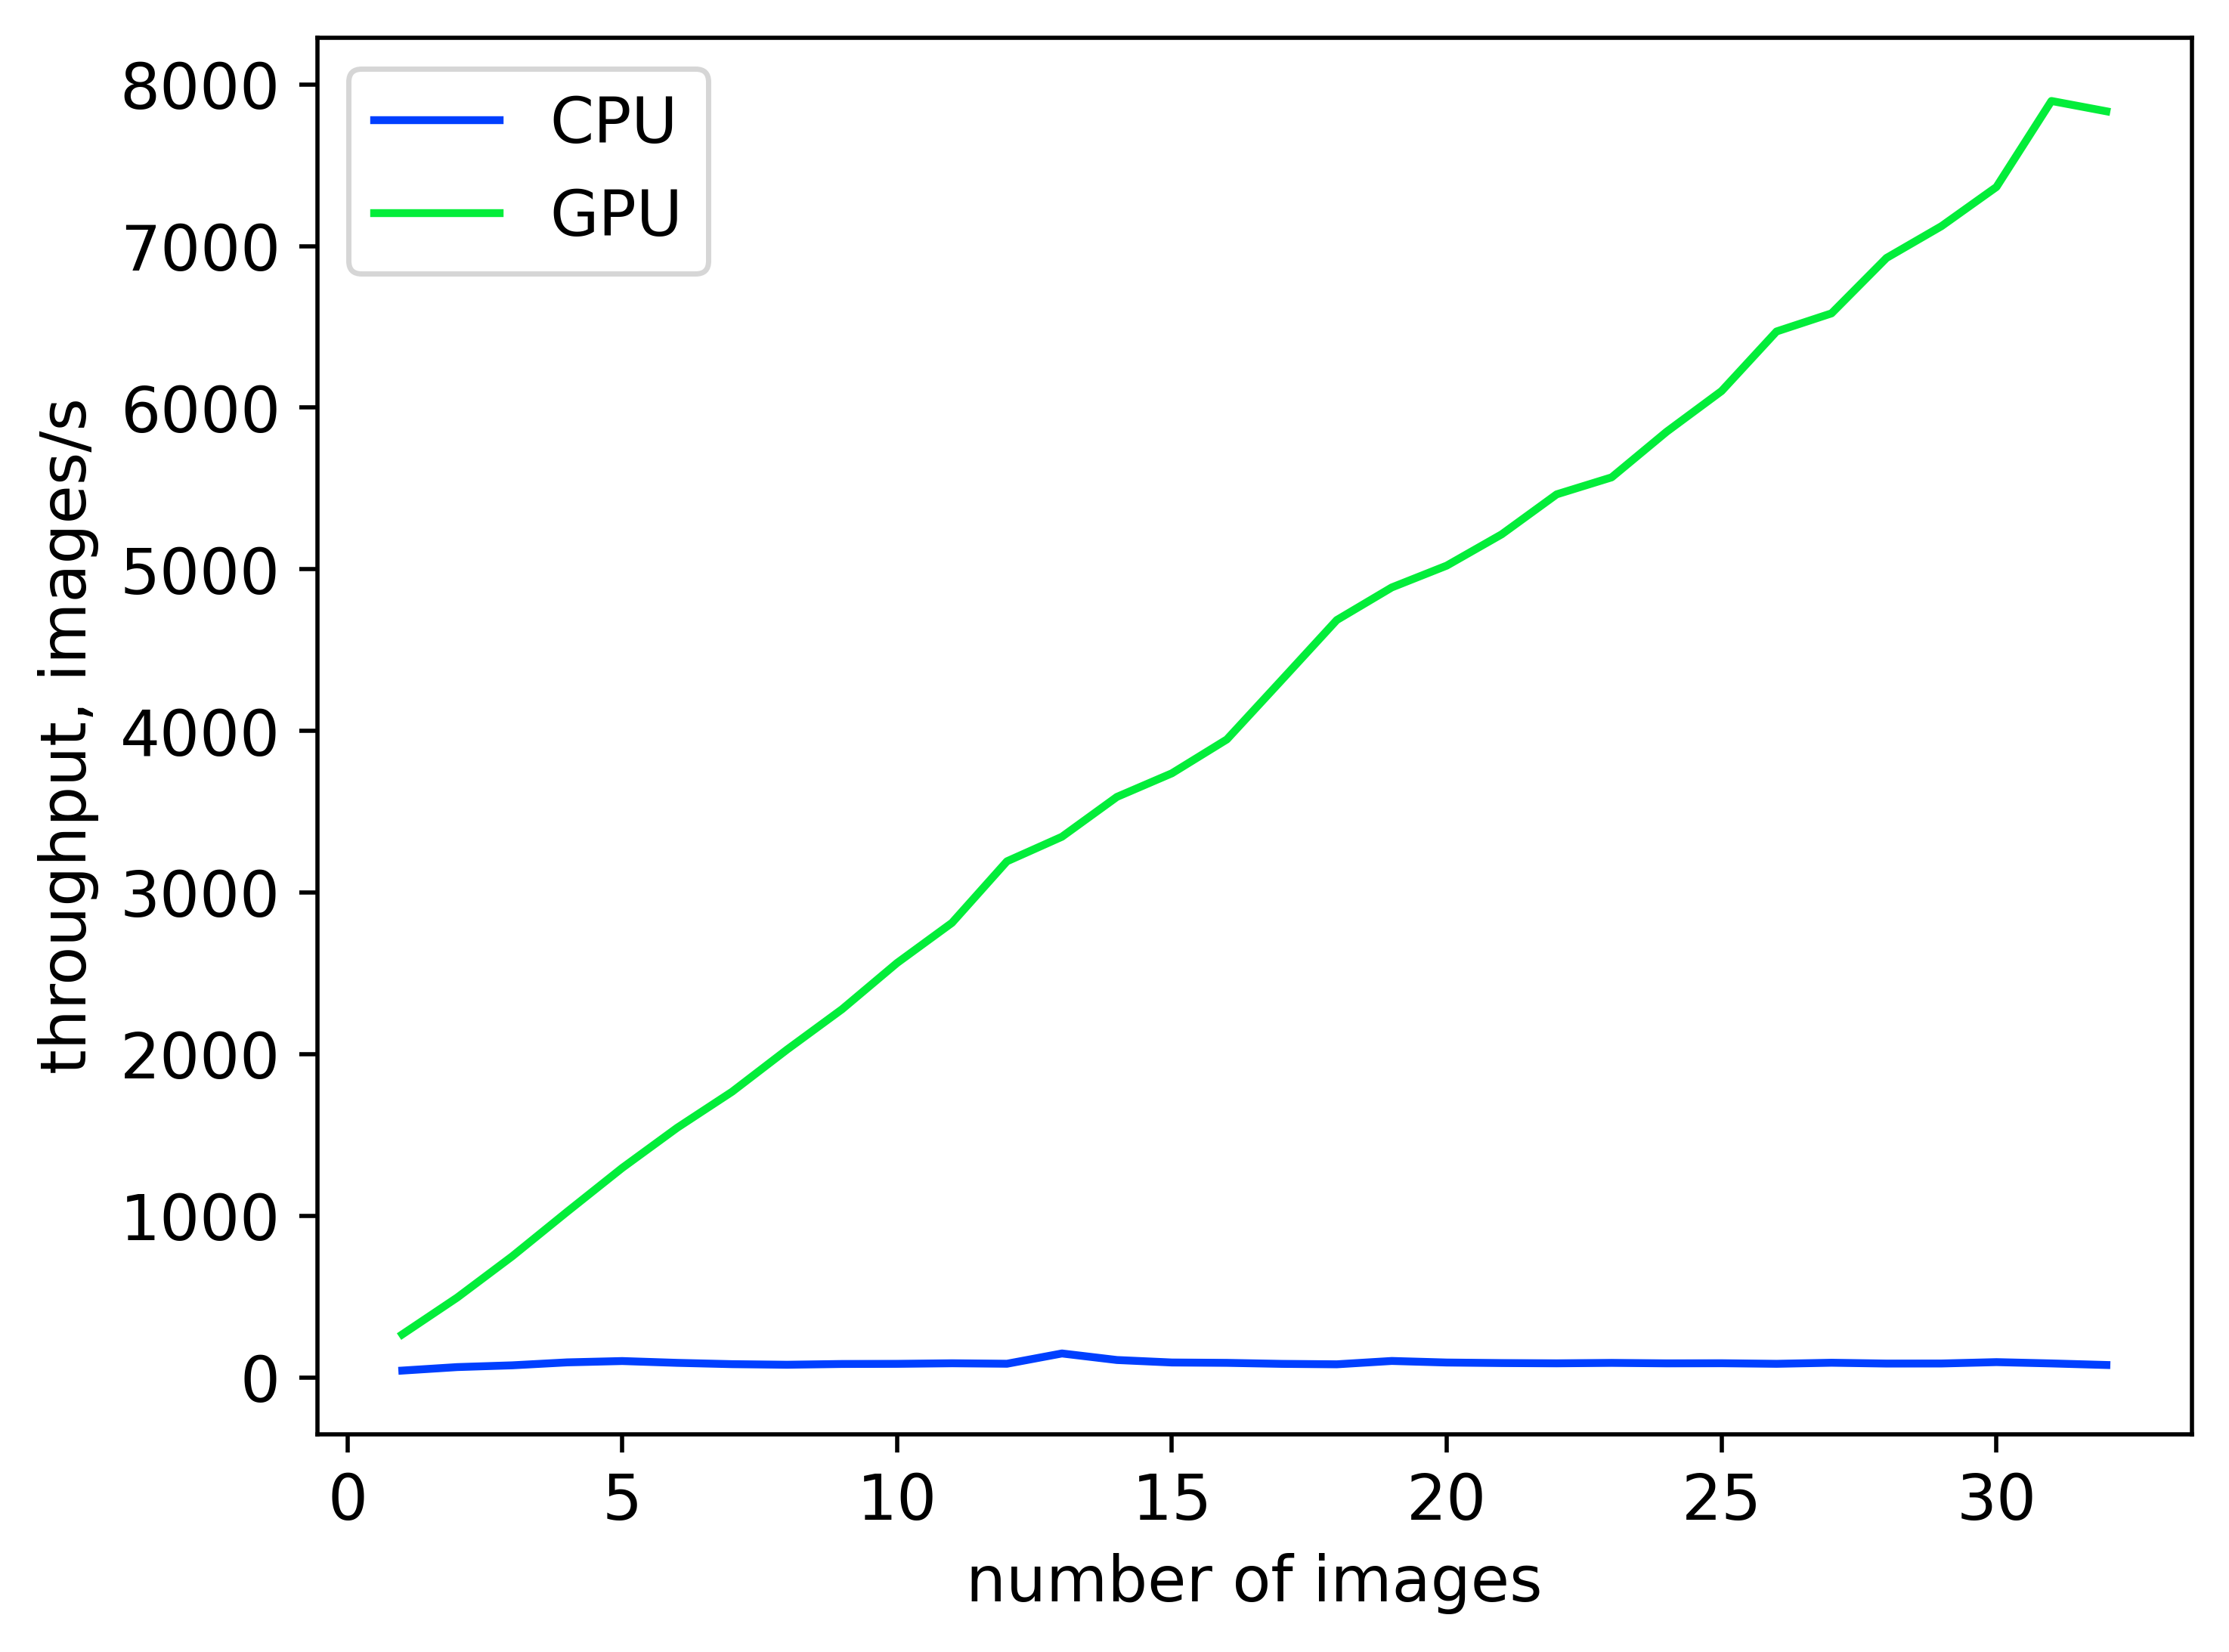

In [163]:
fig, ax = plt.subplots(dpi=dpi)
x = list(range(1, max_batch_size + 1))
ax.plot(x, stats["cpu_throughput"], label="CPU")
ax.plot(x, stats["gpu_throughput"], label="GPU")
ax.set_xlabel("number of images")
ax.set_ylabel("throughput, images/s")
ax.legend()
fig.savefig("throughput.png")

### 2. Metrics on a test dataset

In [5]:
from training_loop import Metrics
from tqdm import tqdm

In [26]:
test_metrics = Metrics(task="binary", num_classes=num_classes, device=device)

with tqdm(total=len(test_dl), dynamic_ncols=True) as pbar:
    pbar.set_description(f"Test: ")
    with torch.no_grad():
        for images, labels in test_dl:
            images = images.to(device)
            labels = labels.to(device)

            prediction = model(images)
            test_metrics.update(prediction, labels)
            
            pbar.update()
            pbar.refresh()

    computed_val_metrics = test_metrics.compute()
    test_metrics.reset()

    pbar.set_postfix(**computed_val_metrics)
    pbar.update(n=0)
    pbar.refresh()

Test: : 100%|██████████| 17/17 [00:07<00:00,  2.17it/s, accuracy=0.892, f1=0.902, precision=0.837, recall=0.977]


## Explainable AI (GradCAM)

In [1]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

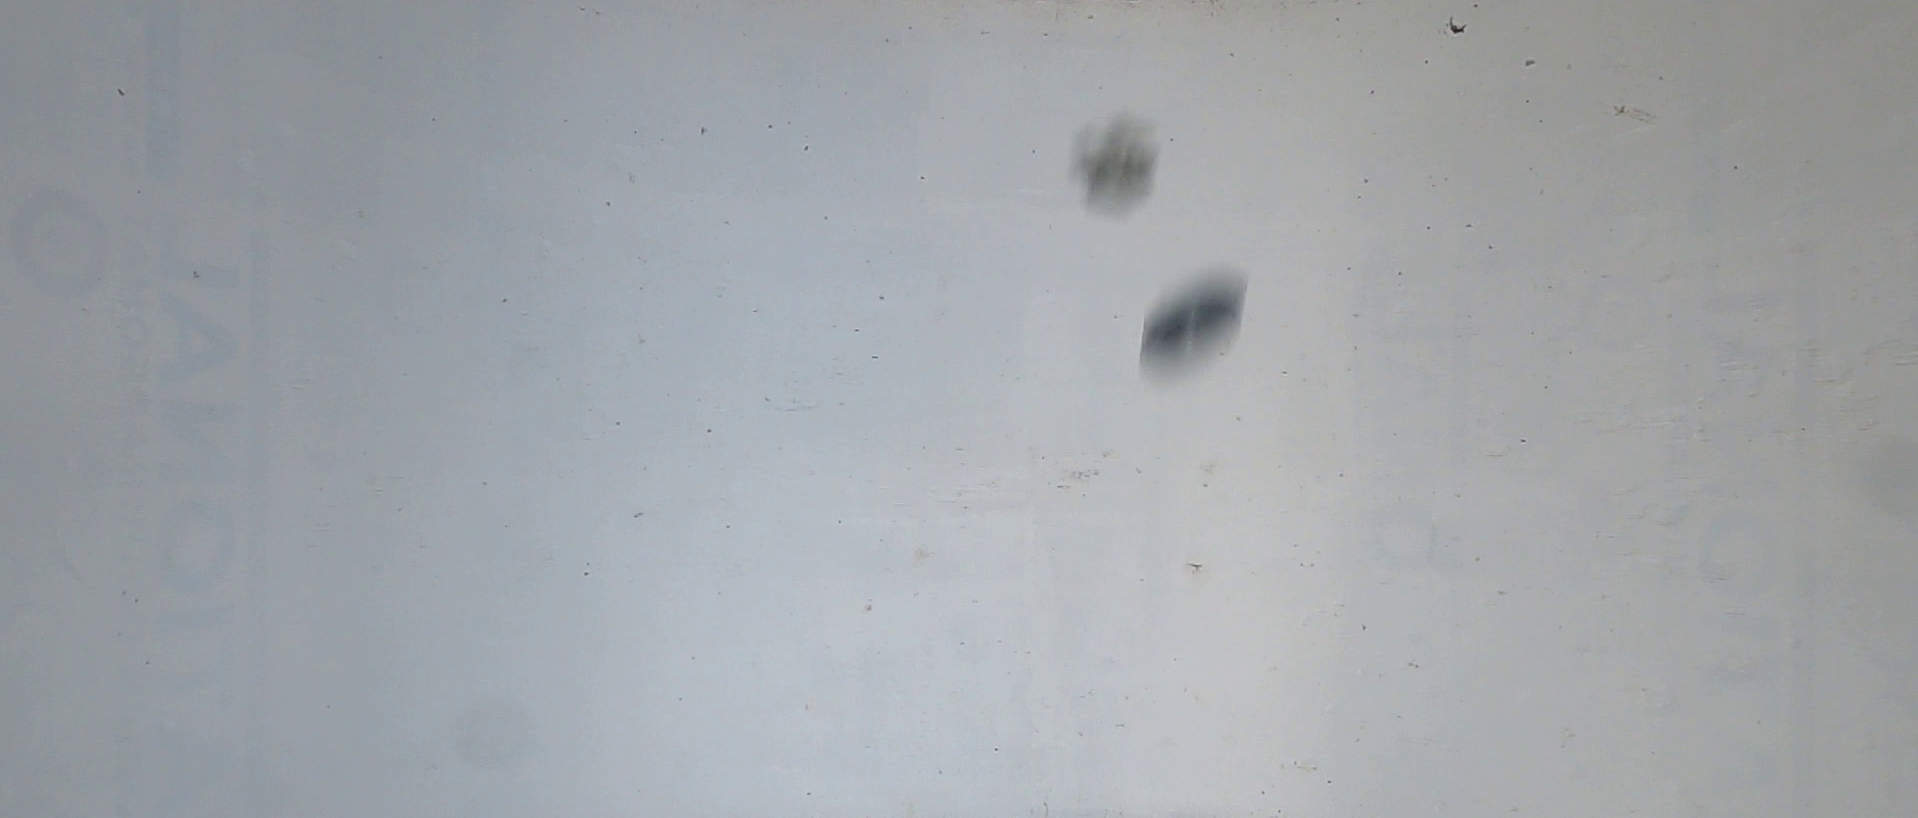

In [2]:
image = Image.open("./Aircraft-FOD-DS-v2-Day-Binary-Reduced/validation/1.abnormal/day_111_044.png")
image.show()

In [3]:
input_tensor = transform(image)
input_tensor = torch.unsqueeze(input_tensor, dim=0)
input_tensor.shape

NameError: name 'transform' is not defined

In [45]:
target_layers = [model.stages[-1].blocks[-1].norm]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
targets = [ClassifierOutputTarget(0)]

In [52]:
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(transform(image), grayscale_cam, use_rgb=True)

TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


In [51]:
np.asarray(image).shape

(818, 1918, 3)

## It doesn't matter :)

In [36]:
model.stages[-1].blocks[-1].norm

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [21]:
param_name = [name for name,_ in model.named_parameters()] # All parameters name
layer_name = [name for name,_ in model.named_modules()] # All layers name

In [22]:
layer_name

['',
 'stem',
 'stem.0',
 'stem.0.se',
 'stem.0.act',
 'stem.0.reparam_conv',
 'stem.1',
 'stem.1.se',
 'stem.1.act',
 'stem.1.reparam_conv',
 'stem.2',
 'stem.2.se',
 'stem.2.act',
 'stem.2.reparam_conv',
 'stages',
 'stages.0',
 'stages.0.downsample',
 'stages.0.pos_emb',
 'stages.0.blocks',
 'stages.0.blocks.0',
 'stages.0.blocks.0.token_mixer',
 'stages.0.blocks.0.token_mixer.reparam_conv',
 'stages.0.blocks.0.mlp',
 'stages.0.blocks.0.mlp.conv',
 'stages.0.blocks.0.mlp.conv.conv',
 'stages.0.blocks.0.mlp.conv.bn',
 'stages.0.blocks.0.mlp.conv.bn.drop',
 'stages.0.blocks.0.mlp.conv.bn.act',
 'stages.0.blocks.0.mlp.fc1',
 'stages.0.blocks.0.mlp.act',
 'stages.0.blocks.0.mlp.fc2',
 'stages.0.blocks.0.mlp.drop',
 'stages.0.blocks.0.layer_scale',
 'stages.0.blocks.0.drop_path',
 'stages.0.blocks.1',
 'stages.0.blocks.1.token_mixer',
 'stages.0.blocks.1.token_mixer.reparam_conv',
 'stages.0.blocks.1.mlp',
 'stages.0.blocks.1.mlp.conv',
 'stages.0.blocks.1.mlp.conv.conv',
 'stages.0.bloc

In [8]:
model_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth',
 'hf_hub_id': 'timm/efficientnet_b3.ra2_in1k',
 'architecture': 'efficientnet_b3',
 'tag': 'ra2_in1k',
 'custom_load': False,
 'input_size': (3, 288, 288),
 'test_input_size': (3, 320, 320),
 'fixed_input_size': False,
 'interpolation': <InterpolationMode.BICUBIC: 'bicubic'>,
 'crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (9, 9),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

In [10]:
model_cfg["input_size"]

(3, 288, 288)

In [63]:
torchinfo.summary(model, input_size=[1, 3, 288, 288], depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [1, 1]                    --
├─Conv2d: 1-1                                 [1, 40, 144, 144]         1,080
├─BatchNormAct2d: 1-2                         [1, 40, 144, 144]         80
│    └─Identity: 2-1                          [1, 40, 144, 144]         --
│    └─SiLU: 2-2                              [1, 40, 144, 144]         --
├─Sequential: 1-3                             [1, 384, 9, 9]            --
│    └─Sequential: 2-3                        [1, 24, 144, 144]         --
│    │    └─DepthwiseSeparableConv: 3-1       [1, 24, 144, 144]         2,298
│    │    └─DepthwiseSeparableConv: 3-2       [1, 24, 144, 144]         1,206
│    └─Sequential: 2-4                        [1, 32, 72, 72]           --
│    │    └─InvertedResidual: 3-3             [1, 32, 72, 72]           11,878
│    │    └─InvertedResidual: 3-4             [1, 32, 72, 72]           18,120
│  